## Scikit-Learn
[Scikit-Learn](https://scikit-learn.org/stable/index.html) is a popular and widely used library, which contains numerous algorithms for machine learning and data analysis. Furthermore, it also contains tools for pre-processing data, evaluating models and many other utilities.

Installing the library is again as easy as issuing one command to the terminal:

In [ ]:
!conda install --yes --prefix {sys.prefix} scikit-learn
# !{sys.executable} -m pip install scikit-learn

### Datasets
Any machine learning algorithm needs some form of input data for training, from which it can recognize patterns and extract knowledge. Usually, several *data points* are collected in experimental or real-world scenarios and merged into a so-called *dataset*. While Scikit-Learn has several utilities for downloading, cleaning and preprocessing such datasets, we are not going use a real-world dataset for the purpose of this exercise. Instead, we will use the function `make_moons` to generate an artifical, two-dimensional dataset in the following code segment. Play around with the `noise` value to see what the data looks like.

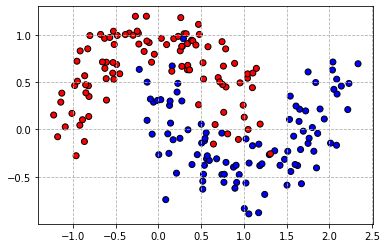

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Generate toy data (two moons dataset)
n = 200
X, Y = datasets.make_moons(n, noise=0.2)

# Plot the dataset
fig = plt.figure()
cmap = ListedColormap([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, edgecolor='k')
plt.grid(linestyle='dashed')
plt.show()
plt.close(fig)

### Classification Fundamentals
The goal of the classification task is to find a function $f$ that assigns a class label $y$, which is chosen from $K$ different possibilities, to a data point $x$. Training data for such a task is usually given as several input-output pairs, i.e., $D = \{(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)\}$. For the two moons dataset, we would have $x \in \mathbb{R}^2$ and $K=2$ and we chose $n=200$.

One cool feature of Scikit-Learn is the unified API that makes it easy to switch between different classification algorithms on the fly. This is possible, since the algorithms are implemented as subclasses of `BaseEstimator` which, among others, offers the following fundamental methods:
* `fit(X, Y)`: This method trains a classifier, where `X` is a Numpy array of shape `(n, d)` containing `n` training examples and `Y` is another Numpy array containg the class labels for all `n` samples. The actual implementation differs significantly from algorithm to algorithm.
* `predict(X)`: Once the classifier has been trained with a call to `fit`, this method can be used to predict a class label for previously unseen datapoints `X` (which is again a Numpy array of shape `(n*, d)`)

The following code snippet uses the *Support-Vector-Machine* algorithm to find a classifier that can distinguish the two classes from the two moons dataset. We use both a linear SVM as well as a RBF-kernel SVM. Don't worry if you have never heard of those terms before, since they will be explained in great detail during the lecture! One great thing about libraries like Scikit-Learn is that you don't need to know how a Support Vector Machine works before you can use it, since the implementation is already available and the library is easily accessible, making it easier for people to get started with machine learning. However, if you want to achieve consistently good results, knowledge about the algorithms you are using and a certain amount of experience are needed in order to know which knobs to tweak. So, it still makes sense to attend to lecture (at least digitally) :)

For the two-dimensional toy dataset used in this exercise it is also easy to draw the decision surface of the classifier. This means that a point within the blue surface would be classfied as blue by the classifier and a point in the red surface as belonging to the red class. As you can see by playing around, the boundary between the classes is always a line for the linear SVM, whereas it can have any shape for the RBF SVM.

There are several ways to evaluate and compare the performance of classifiers, but one easy and often used way is to separate a certain number of randomly chosen points from the given dataset (the *test set*) and use the rest to train the classifier (the *training set*). The percentage of correctly classified points in the test set, called *accuracy*, can then be seen as a measure of the *generalization* performance, i.e., the classifier's ability to transfer learned patterns to a set of similar data that it has never seen before. Scikit-Learn's `train_test_split` function implements exactly this split of data in training and test samples.

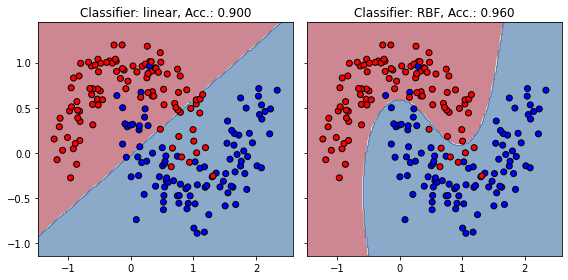

In [2]:
from sklearn.svm import SVC
import numpy as np

# Train Classifier on the dataset
linear_clf = SVC(kernel='linear', C=0.1)
kernel_clf = SVC(kernel='rbf', C=1, gamma=1)

classifiers = [(linear_clf, 'linear'),
               (kernel_clf, 'RBF')]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

# Plot decision surface
# First generate grid
res = 200  # Resolution of the grid in cells
x_max, y_max = np.max(X, axis=0) + 0.25
x_min, y_min = np.min(X, axis=0) - 0.25
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, res),
                             np.linspace(y_min, y_max, res))
# Get test array from grid
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]

rows = (len(classifiers) + 1) // 2
fig, axes = plt.subplots(rows, 2, sharex=True, sharey=True, figsize=(8, 4*rows))
for (clf, name), ax in zip(classifiers, axes.ravel()):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    grid_out = clf.predict(grid_input).reshape(grid_x.shape)

    ax.set_title(f'Classifier: {name}, Acc.: {score:.3f}')
    ax.contourf(grid_x, grid_y, grid_out, alpha=0.5, cmap=plt.cm.RdBu)
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, edgecolor='k')
plt.tight_layout()
plt.show()
plt.close(fig)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### $k$-Nearest Neighbours (Task to Complete)
One of the simplest machine learning algorithms (in fact so simple that you will probably be able to find convincing arguments that it is not a machine learning algorithm at all) is the $k$-nearest neighbours algorithm. Given some training examples $D = \{(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)\}$ and a test point $x^*$, for which we would like to predct a class label, the algorithm works as follows:
* **Training**: The training examples $D = \{(x_i, y_i)\}_{i=1}^{n}$ are stored.
* **Prediction**: The $k$ training points with the least distance to $x^*$ are fetched along with their class labels, i.e.
\begin{equation*}
    P_{x^*}^k := \operatorname{arg\ min}_{\{y_{i_1}, \ldots, y_{i_k}\}} \sum_{j=1}^{k} d(x_{i_j}, x^*),
\end{equation*}
where $d$ is some distance measure. The class that appears most often in that set is then returned as the class label of $x^*$. In case of a tie, one could, for example, choose a class randomly or according to some other tie-breaker rule.

Your tasks are as follows:
1. Implement the $k$-nearest neighbours algorithm by filling in the gaps in the skeleton that has already been prepared for you. Use the Euclidean distance and when a tie occurs break it by deterministically choosing the smallest class label.
2. Note that the `KNN` class conforms to the API of Scikit-Learn. Compare what happens when you use different values for $k$, namely $k \in \{1, 2, 5, 10, 15, 20\}$. How do the decision surfaces for different values of $k$ look like when training on the two moons dataset?
3. Can you think of a disadvantage the $k$-NN classifier might have when it is applied to real-world datasets? Insert a new markdown cell at the end of the notebook and state one such disadvantage together with two or three sentences where you explain the problem.

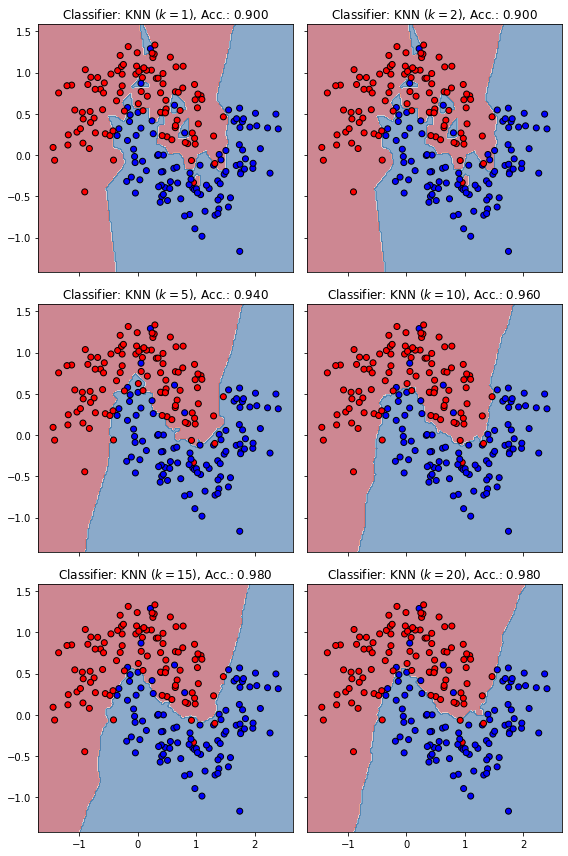

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter

def euclidean_distance(a, b, keepdims=False):
    distance = np.sum((a-b)**2)
    return np.sqrt(distance)

class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5, dist_function=euclidean_distance):
        super(KNN, self).__init__()

        self.k = k
        self.dist_function = dist_function
        self.train_points = None
        
    def fit(self, X, Y):
        # TODO:
        self.train_points = X
        self.train_labels = Y
        return self
    def predict(self, X):
        #TODO:
        results = []
        for x in X:
            distances = [self.dist_function(Xi,x) for Xi in self.train_points]
            k_indices = np.argsort(distances)[:self.k]
            k_labels = [self.train_labels[i] for i in k_indices]
            results.append(Counter(k_labels).most_common(1)[0][0])
        return np.array(results)
        

# Generate toy data (two moons dataset)
# Please don't modify this part for this exercise
n = 200
X, Y = datasets.make_moons(n, noise=0.25, random_state=1234)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)
# From now on you can modify stuff again
x_max, y_max = np.max(X, axis=0) + 0.25
x_min, y_min = np.min(X, axis=0) - 0.25
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, res),
                             np.linspace(y_min, y_max, res))
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]
classifiers = [(KNN(k), f'KNN ($k={k}$)') for k in [1, 2, 5, 10, 15, 20]]
rows = (len(classifiers) + 1) // 2
fig, axes = plt.subplots(rows, 2, sharex=True, sharey=True, figsize=(8, 4*rows))
for (clf, name), ax in zip(classifiers, axes.ravel()):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    grid_out = clf.predict(grid_input).reshape(grid_x.shape)

    ax.set_title(f'Classifier: {name}, Acc.: {score:.3f}')
    ax.contourf(grid_x, grid_y, grid_out, alpha=0.5, cmap=plt.cm.RdBu)
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, edgecolor='k')
plt.tight_layout()
plt.show()
plt.close(fig)
# TODO: Plot decision surfaces

The disadvantage of knn is that it memories the traing data and as the dataset size increases and there are more training data it fills up the memory if you talk about real world data as the real world data is usually very large and of multiple dimensions or it contains many features. Also during prediction on test data it will also take more time. This can be easily understood by running the above cell as for only 6 knn and 200 total samples it takes considerable time on my machine to run.